# スムージング
- 出現確率を問うような観測データの中に、一度も出てこないパターンがあった場合、算術平均ではその単語の出現率が0となってしまう。これを回避する手法

## 例
- コインを3回投げたらすべて表だった場合の裏となる確率
    - 0/3 = 0
- 最初から表と裏に1ずつ足してから計算してあげる
    - 1 / 5 = 0.2
    - 「出うるパターンすべてに<font color='red'>1ずつ</font>足してから計算してあげる」ことをラプラススムージングという

# 推定について
- 算術平均で真の確率pを求めるのは最尤推定
    - 最尤推定 = 分布の山の一番高いところを推定値とする点推定

## 例

In [1]:
from scipy.stats import binom, dirichlet, multinomial, beta
import pandas as pd
from itertools import product

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
plt.rcParams['font.size'] = 17

In [55]:
import seaborn as sns

In [3]:
from scipy.stats import beta
import numpy as np
a, b = 1, 4
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
y = beta.pdf(x, a, b)

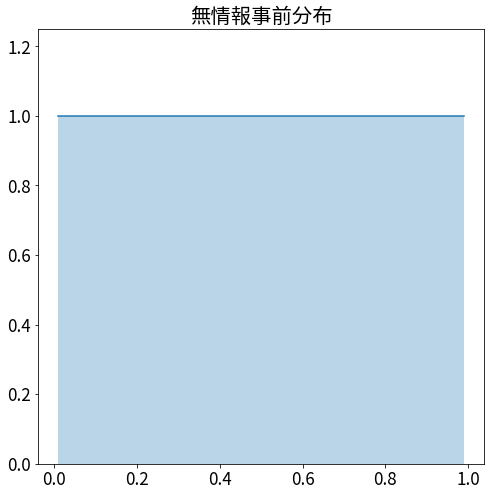

In [12]:
a, b = 1, 1
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
y = beta.pdf(x, a, b)
plt.figure(figsize=(8, 8))
plt.plot(x, y)
plt.title('無情報事前分布')
plt.fill_between(x, np.zeros(len(y)), y, alpha=0.3)
plt.ylim(0, 1.25)
plt.savefig('data_folder/無情報事前分布.png', bbox_inches='tight', pad_inches=0.3)
plt.show()

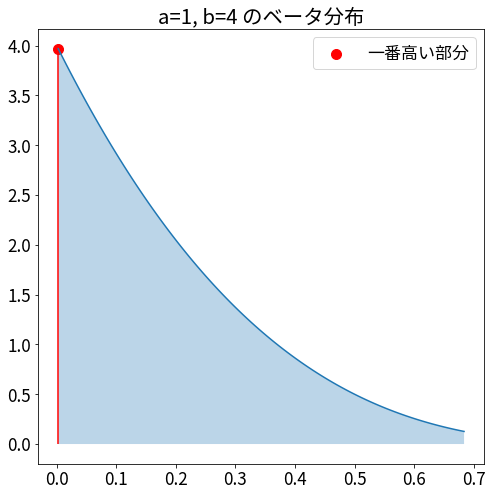

In [4]:
plt.figure(figsize=(8, 8))
plt.plot(x, y)
plt.title('a=1, b=4 のベータ分布')
plt.scatter(x[0], y[0], s=100, color='red', label='一番高い部分')
plt.fill_between(x, np.zeros(len(y)), y, alpha=0.3)
plt.vlines(x[0], 0, y[0], color='red')
plt.legend(loc='upper right')
plt.show()

- 上のグラフは実はラプラススムージングをしている分布
    - このベータ分布の期待値を推定値とする = ベイズ推定量
        - 事前分布、事後分布の解釈が必要
    - ベータ分布の期待値 = a / (a + b) = 1 / 5 = 0.2

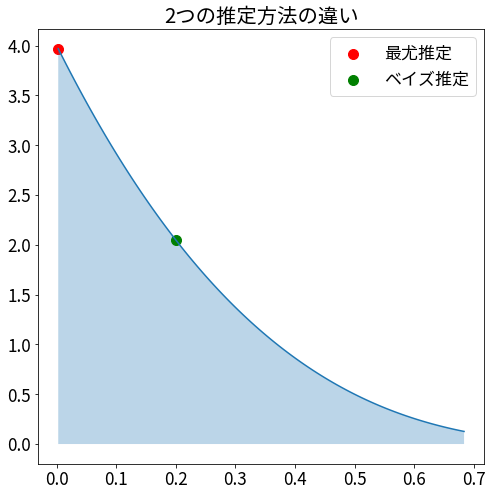

In [7]:
plt.figure(figsize=(8, 8))
plt.plot(x, y)
plt.title('2つの推定方法の違い')
plt.scatter(x[0], y[0], s=100, color='red', label='最尤推定')
plt.fill_between(x, np.zeros(len(y)), y, alpha=0.3)
plt.scatter(0.2, beta.pdf(0.2, a, b), s=100, color='green', label='ベイズ推定')
plt.legend(loc='upper right')
plt.savefig('data_folder/推定方法の違い.png', bbox_inches='tight', pad_inches=0.3)
plt.show()

### 「コインを3回投げたらすべて表だった場合の裏となる確率」についての推定
- 0/3 = 最尤推定
- 1 / 5 = ベイズ推定

# この推定方法は最尤推定より優れているのか？
- 真の確率pを 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1とする
- 試行回数nを 3, 5, 10, 30, 50, 100, 500, 1000とする
1. 上記の全パターンを1000回ずつ試行
2. それぞれの推定法を比べてどちらが近かったかを見る

In [6]:
n = np.array([3, 5, 10, 30, 50, 100, 500, 1000])
p = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1])

In [7]:
def estimate_simulate(n, p):
    # 成功回数
    x = binom.rvs(n, p, size=100000)
    # 最尤推定
    maximum_likelihood = x / n
    # ベイズ推定
    bayes = (x + 1) / (n + 2)
    
    # 真の確率との差を比較
    estimate_diff_ml = np.abs(maximum_likelihood - p)
    estimate_diff_b = np.abs(bayes - p)
    # ベイズ推定のほうが真の確率との誤差が小さい場合1を返す
    result = np.int64(estimate_diff_b < estimate_diff_ml)
    
    # DataFrameを返す
    return pd.DataFrame({
        'n': n,
        'p' : p,
        'ml_estimate' : maximum_likelihood,
        'b_estimate' : bayes,
        'ml_diff' : estimate_diff_ml,
        'b_diff' : estimate_diff_b,
        'result' : result
    })

In [8]:
dfs = []
for v in list(product(n, p)):
    dfs.append(estimate_simulate(v[0], v[1]))

In [9]:
df = pd.concat(dfs)
df

,n,p,ml_estimate,b_estimate,ml_diff,b_diff,result
0,3,0.5,0.333333,0.400000,0.166667,0.100000,1
1,3,0.5,0.333333,0.400000,0.166667,0.100000,1
2,3,0.5,0.333333,0.400000,0.166667,0.100000,1
3,3,0.5,0.666667,0.600000,0.166667,0.100000,1
4,3,0.5,0.666667,0.600000,0.166667,0.100000,1
...,...,...,...,...,...,...,...
99995,1000,1.0,1.000000,0.999002,0.000000,0.000998,0
99996,1000,1.0,1.000000,0.999002,0.000000,0.000998,0
99997,1000,1.0,1.000000,0.999002,0.000000,0.000998,0
99998,1000,1.0,1.000000,0.999002,0.000000,0.000998,0


## 確率p毎の集計
- 真の確率が<font color='red'>0.5に近いほどベイズ推定のほうが良い推定</font>
- <font color='red'>1に近づくと最尤推定のほうが良い推定</font>
    - 真の確率pが1の場合、ベイズ推定では推定値として1が出てこないので必ず負ける

In [10]:
df.groupby(['p'], as_index=False)[['ml_diff','b_diff','result']].mean()

,p,ml_diff,b_diff,result
0,0.50,0.094918,0.072225,0.919582
1,0.60,0.088870,0.068348,0.585795
2,0.70,0.084012,0.068441,0.499839
3,0.80,0.073814,0.061564,0.461130
4,0.90,0.056223,0.058995,0.403909
5,0.95,0.038879,0.059696,0.386171
6,1.00,0.000000,0.061183,0.000000


## 試行回数nと確率p毎の集計
- 0.5に近づくほど少ない試行回数で最尤推定よりも良い推定ができる
- 1に近づくほど少ない試行回数では最尤推定より良い推定ができない
    - ラプラススムージングは最初にそれぞれ1ずつ足す = 確率が一様 とするため、こうなりやすい
    - 最適な足し方を研究しているページ
        - https://www.slideshare.net/nakanotomofumi/ss-62387360

In [11]:
df.groupby(['p','n'], as_index=False)[['ml_diff','b_diff','result']].mean()

,p,n,ml_diff,b_diff,result
0,0.50,3,0.249650,0.149790,1.00000
1,0.50,5,0.187634,0.134024,1.00000
2,0.50,10,0.123068,0.102557,0.75396
3,0.50,30,0.072326,0.067805,0.85547
4,0.50,50,0.056293,0.054128,0.88753
5,0.50,100,0.039948,0.039164,0.92045
6,0.50,500,0.017814,0.017743,0.96442
7,0.50,1000,0.012610,0.012585,0.97483
8,0.60,3,0.230642,0.126466,1.00000
9,0.60,5,0.165712,0.127822,0.65328


## 真の確率pもランダムにして推定値を評価

In [12]:
def estimate_simulate_prand(n):
    p = np.random.random(size=100000)
    # 成功回数
    x = binom.rvs(n, p)
    # 最尤推定
    maximum_likelihood = x / n
    # ベイズ推定
    bayes = (x + 1) / (n + 2)
    
    # 真の確率との差を比較
    estimate_diff_ml = np.abs(maximum_likelihood - p)
    estimate_diff_b = np.abs(bayes - p)
    # ベイズ推定のほうが真の確率との誤差が小さい場合1を返す
    result = np.int64(estimate_diff_b < estimate_diff_ml)
    
    # DataFrameを返す
    return pd.DataFrame({
        'n': n,
        'p' : p,
        'ml_estimate' : maximum_likelihood,
        'b_estimate' : bayes,
        'ml_diff' : estimate_diff_ml,
        'b_diff' : estimate_diff_b,
        'result' : result
    })

In [13]:
dfs = []
for v in n:
    dfs.append(estimate_simulate_prand(v))
df1 = pd.concat(dfs)

## 真の確率pがランダムに採択される場合、ほとんどの試行回数でベイズ推定のほうが最尤推定より誤差が小さくなる

In [14]:
df1[['ml_diff','b_diff','result']].mean()

ml_diff    0.073056
b_diff     0.065041
result     0.525115
dtype: float64

In [15]:
df1.groupby('n', as_index=False)[['ml_diff','b_diff','result']].mean()

,n,ml_diff,b_diff,result
0,3,0.185019,0.148358,0.59423
1,5,0.142218,0.123926,0.56854
2,10,0.099736,0.092798,0.50103
3,30,0.057551,0.056179,0.51004
4,50,0.044442,0.043831,0.50996
5,100,0.031477,0.031258,0.50857
6,500,0.014068,0.014046,0.50623
7,1000,0.009936,0.009930,0.50232


### とはいえ現実世界での分析は大体真の確率pはランダムになんてならない
- 商品ごとの購入率/バスケット率
- 広告ごとの広告クリック率

これらは事前分布（要するに最初に施した1ずつ足すの行為）を変更することによってベイズ推定値の改善をさせることができる

これは後程

# 多項条件でも同じことができる
- 二項分布は多項分布の項数が2のモデル
- 項の数だけそれぞれ<font color='red'>1を足して</font>あげればそれはラプラススムージング

## 例
- 項を5として考える
    - それぞれの項の誤差を2乗したものを5で割り、1/2乗する(RMSE)

## 真の確率pをランダムにして推定値を評価

In [33]:
n = np.array([3, 5, 10, 30, 50, 100, 500, 1000, 10000])

In [34]:
def estimate_simulate_prand_multi(n):
    p = dirichlet.rvs(np.repeat(0.2, 5), size=1000)
    # それぞれの採択回数 (計算仕様上p_の総和が1を超える時がある)
    x = np.array([multinomial.rvs(n, p_) for p_ in p])
    # 最尤推定
    maximum_likelihood = x / n
    # ベイズ推定
    bayes = (x + np.ones(5)) / (n + 5)
    
    # 真のpとの差を比較
    estimate_diff_ml = np.sqrt(np.sum(np.square(maximum_likelihood - p), axis=1) / 5)
    estimate_diff_b = np.sqrt(np.sum(np.square(bayes - p), axis=1) / 5)
    
    # ベイズ推定のほうが真の確率との誤差が小さい場合1を返す
    result = np.int64(estimate_diff_b < estimate_diff_ml)
    # DataFrameを返す
    return pd.DataFrame({
        'n' : n,
        'ml_diff' : estimate_diff_ml,
        'b_diff' : estimate_diff_b,
        'result' : result
    })

In [36]:
dfs = []
for v in n:
    dfs.append(estimate_simulate_prand_multi(v))
df2 = pd.concat(dfs)

多項の場合ラプラススムージングは良くなさそう

In [37]:
df2[['ml_diff','b_diff','result']].mean()

ml_diff    0.048111
b_diff     0.064338
result     0.368556
dtype: float64

In [38]:
df2.groupby(['n'], as_index=False)[['ml_diff','b_diff','result']].mean()

,n,ml_diff,b_diff,result
0,3,0.130062,0.181160,0.342
1,5,0.109563,0.148766,0.341
2,10,0.073728,0.104877,0.298
3,30,0.041941,0.055701,0.293
4,50,0.033691,0.040750,0.347
5,100,0.023866,0.027011,0.378
6,500,0.010438,0.010876,0.413
7,1000,0.007375,0.007564,0.433
8,10000,0.002335,0.002339,0.472


# スムージングのパラメータを推定しよう
- スムージング時のパラメータ（超パラメータ）を推定
    - https://www.slideshare.net/nakanotomofumi/ss-62387360

## 例
- 真の確率pが以下のような分布からランダムで算出されるとする
    - つまりは上記で示したような0 ~ 1間で一様な確率ではなくある程度偏りがある

In [40]:
a, b = 45, 5
beta_x = np.linspace(beta.ppf(0.001, a, b), beta.ppf(0.999, a, b), 1000)
beta_y = beta.pdf(beta_x, a, b)

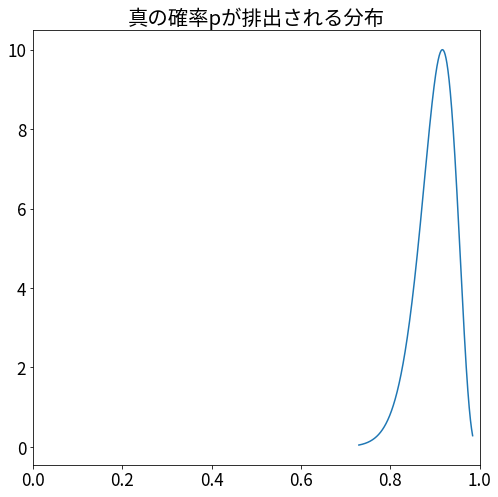

In [41]:
plt.figure(figsize=(8, 8))
plt.plot(beta_x, beta_y)
plt.xlim(0, 1)
plt.title('真の確率pが排出される分布')
plt.savefig('data_folder/真の確率p排出分布.png', bbox_inches='tight', pad_inches=0.3)
plt.show()

上記分布から1個確率pを観測値として取り出す

In [184]:
obs = beta.rvs(a, b, random_state=46)

確率pが過去案件だとする

案件で100のサンプルを使用した

In [185]:
from scipy.stats import binom

そしたら83サンプルが反応（陽）した

In [187]:
binom.rvs(100, obs, random_state=46)

83

これを事前分布の情報として入れる

In [191]:
from scipy.special import psi

In [188]:
def new_hyperprior(x, a, b, loop=1000):
    for l in range(loop):
        a_t__a_b = 0
        a_b = 0
        b_t__a_b = 0
        for (i, c) in x:
            if c != 0:
                a_t__a_b += psi(c+a) - psi(a)
            a_b_ = psi(i+a+b) - psi(a+b)
            a_b += a_b_
            a_t__a_b -= a_b_
            b_t__a_b += psi(i-c+b) - psi(b)
            b_t__a_b -= a_b_
        a_r = a_t__a_b / a_b
        a = a_r * a + a
        b_r = b_t__a_b / a_b
        b = b_r * b + b
        if (l % 1000 == 0):
            print(f'l:{l}, a:{a: .15f}, b:{b: .15f}')
        # if (np.abs(a_r) < EPSILON) & (np.abs(b_r) < EPSILON): EPSILON変数がどこで作られてるのか不明なためスルー 両方誤差より小さければ実行を打ち止めするものっぽい
        #     break
    print(f'l:{l} a:{a: .15f}, b:{b: .15f}')

In [192]:
new_hyperprior([(100, 83)], 1, 2)

l:0, a: 1.349327501631762, b: 1.346130346857474
l:999 a: 303.577507284060573, b: 62.575505272794054


$a = 303.57, b = 62.57$と結果が出たのでこれを事前パラメータの値とする

In [44]:
def estimate_simulate_betaprand(n, alpha_, beta_):
    # 真の成功確率pを上記のベータ分布とする
    p = beta.rvs(a=45, b=5, size=100000)
    # 成功回数
    x = binom.rvs(n, p)
    # 最尤推定
    maximum_likelihood = x / n
    # ベイズ推定
    bayes = (x + alpha_) / (n + alpha_ + beta_)
    
    # 真の確率との差を比較
    estimate_diff_ml = np.abs(maximum_likelihood - p)
    estimate_diff_b = np.abs(bayes - p)
    # ベイズ推定のほうが真の確率との誤差が小さい場合1を返す
    result = np.int64(estimate_diff_b < estimate_diff_ml)
    
    # DataFrameを返す
    return pd.DataFrame({
        'n': n,
        'p' : p,
        'ml_estimate' : maximum_likelihood,
        'b_estimate' : bayes,
        'ml_diff' : estimate_diff_ml,
        'b_diff' : estimate_diff_b,
        'result' : result
    })

まずはラプラススムージングで行う

In [225]:
dfs = []
for v in n:
    dfs.append(estimate_simulate_betaprand(v, 1, 1))
df3 = pd.concat(dfs)

In [226]:
df3.describe()

,n,p,ml_estimate,b_estimate,ml_diff,b_diff,result
count,800000.000000,800000.000000,800000.000000,800000.000000,8.000000e+05,8.000000e+05,800000.000000
mean,212.250000,0.900012,0.899926,0.851048,5.503092e-02,5.935254e-02,0.432809
std,335.993793,0.041948,0.097624,0.091819,6.882713e-02,7.724342e-02,0.495465
min,3.000000,0.591676,0.000000,0.142857,8.845657e-08,2.702742e-08,0.000000
25%,8.750000,0.874917,0.862000,0.807692,1.002156e-02,9.475915e-03,0.000000
50%,40.000000,0.905291,0.911000,0.865385,3.120204e-02,2.814390e-02,0.000000
75%,200.000000,0.930732,0.970000,0.916667,7.731453e-02,8.001207e-02,1.000000
max,1000.000000,0.996271,1.000000,0.998008,9.384297e-01,7.751363e-01,1.000000


In [227]:
df3.groupby(['n'], as_index=False)['result'].mean()

,n,result
0,3,0.32073
1,5,0.41042
2,10,0.41410
3,30,0.43319
4,50,0.44781
5,100,0.46570
6,500,0.48299
7,1000,0.48753


超パラメータ推定で出た値を使う

In [45]:
dfs = []
for v in n:
    dfs.append(estimate_simulate_betaprand(v, 303.57, 62.57))
df4 = pd.concat(dfs)

In [46]:
df4.describe()

,n,p,ml_estimate,b_estimate,ml_diff,b_diff,result
count,900000.000000,900000.000000,900000.000000,900000.000000,9.000000e+05,9.000000e+05,900000.000000
mean,1299.777778,0.900037,0.900085,0.850631,4.912818e-02,5.194967e-02,0.350591
std,3092.263270,0.042040,0.092826,0.031126,6.661187e-02,3.749959e-02,0.477155
min,3.000000,0.580787,0.000000,0.589474,6.072810e-09,6.210824e-08,0.000000
25%,10.000000,0.875014,0.866000,0.830498,6.037005e-03,1.910696e-02,0.000000
50%,50.000000,0.905334,0.910000,0.837002,2.373837e-02,4.734587e-02,0.000000
75%,500.000000,0.930837,0.965200,0.861951,7.013263e-02,8.189578e-02,1.000000
max,10000.000000,0.997519,1.000000,0.988079,9.478402e-01,2.280376e-01,1.000000


In [47]:
df4.groupby(['n'], as_index=False)['result'].mean()

,n,result
0,3,0.66602
1,5,0.69512
2,10,0.48569
3,30,0.26215
4,50,0.23176
5,100,0.17321
6,500,0.14982
7,1000,0.16961
8,10000,0.32194


## サンプル数が少ない時は最尤法より良い推定値になるが、多くなると特に良いものではなくなる
- じゃあ何がいいのか
    - https://norimune.net/708

「どっちがより良いか」の1か0の判断の場合、最尤法に負けてしまうが「負け」ていてもその誤差は小さい

In [53]:
df4_melt = pd.melt(df4.rename(columns={'ml_diff':'算術平均', 'b_diff':'スムージング'}), id_vars='n', value_vars=['算術平均','スムージング'])
df4_melt

,n,variable,value
0,3,算術平均,0.281328
1,3,算術平均,0.108633
2,3,算術平均,0.446208
3,3,算術平均,0.176032
4,3,算術平均,0.138176
...,...,...,...
1799995,10000,スムージング,0.000687
1799996,10000,スムージング,0.001350
1799997,10000,スムージング,0.003961
1799998,10000,スムージング,0.001222


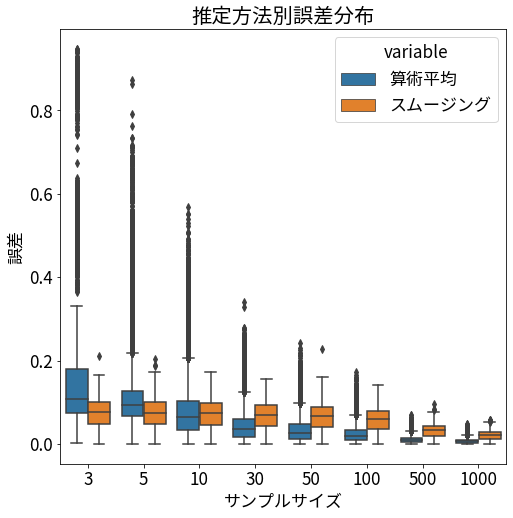

In [63]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=df4_melt[df4_melt['n'] != 10000], x='n', y='value', hue='variable', orient='v')
plt.title('推定方法別誤差分布')
plt.xlabel('サンプルサイズ')
plt.ylabel('誤差')
plt.savefig('data_folder/それぞれの誤差分布.png', bbox_inches='tight', pad_inches=.3)
plt.show()

In [66]:
a = 950 + 303 ; b = 50 + 62
x = np.linspace(beta.ppf(0.001, a, b), beta.ppf(0.999, a, b), 1000)
y = beta.pdf(x, a, b)

In [79]:
beta.mean(a, b)

0.9179487179487179

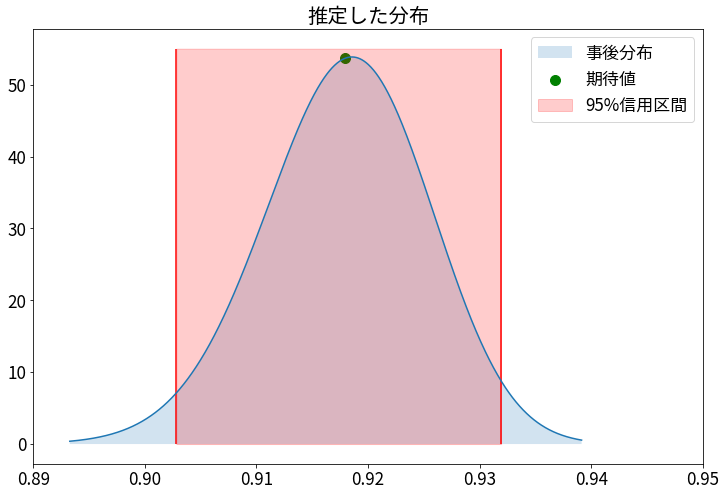

In [92]:
plt.figure(figsize=(12, 8))
plt.plot(x, y)
plt.fill_between(x, 0, y, alpha=0.2, label='事後分布')
plt.vlines(beta.ppf(0.025, a, b), 0, 55, color='red')
plt.vlines(beta.ppf(0.975, a, b), 0, 55, color='red')
plt.scatter(beta.mean(a, b), beta.pdf(beta.mean(a, b), a, b), color='green', s=100, label='期待値')
plt.fill_between(np.linspace(beta.ppf(0.025, a, b), beta.ppf(0.975, a, b), 1000), 0, 55, alpha=0.2, color='red', label='95%信用区間')
plt.title('推定した分布')
plt.legend(loc='upper right')
plt.xlim(0.89, 0.95)
plt.savefig('data_folder/ベイズ推定.png', bbox_inches='tight', pad_inches=0.3)
plt.show()

In [93]:
beta.mean(a, b)

0.9179487179487179

In [94]:
beta.ppf(0.025, a, b)

0.9028261213156711

In [95]:
beta.ppf(0.975, a, b)

0.9319118015844583

In [ ]:
plt.figure(figsize=())